In [31]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint
from datetime import datetime

sys.path.append('../..')

In [32]:
# from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import general_arbitrage, invest_all
from model.amm.global_state import GlobalState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.exchange import Exchange
from model import run
import model.plot_utils as pu

class CEXDummy(Exchange):
    def __init__(self, tokens: dict[str: float], trade_fee=0, unique_id='dummy exchange'):
        super().__init__()
        self.prices = tokens
        self.liquidity = {tkn: 0 for tkn in tokens}
        self.asset_list = list(tokens.keys())
        self.unique_id = unique_id
        self.trade_fee = trade_fee

    def price(self, tkn: str, denomination: str = ''):
        if denomination and denomination not in self.prices:
            raise ValueError(f'Denomination {denomination} not in exchange')
        return self.prices[tkn] / (self.prices[denomination] if denomination in self.prices else 1)

    def buy_spot(self, tkn_buy, tkn_sell, fee=0):
        return self.price(tkn_buy) / self.price(tkn_sell) / (1 - self.trade_fee)

    def sell_spot(self, tkn_sell, tkn_buy, fee=0):
        return self.price(tkn_sell) / self.price(tkn_buy) * (1 - self.trade_fee)

    def buy_limit(self, tkn_buy, tkn_sell):
        return float('inf')

    def sell_limit(self, tkn_buy, tkn_sell):
        return float('inf')
    
    def swap(
            self,
            agent: Agent,
            tkn_buy: str,
            tkn_sell: str,
            buy_quantity: float = 0,
            sell_quantity: float = 0
    ):
        if buy_quantity:
            sell_quantity = self.calculate_sell_from_buy(tkn_buy, tkn_sell, buy_quantity)
        elif sell_quantity:
            buy_quantity = self.calculate_buy_from_sell(tkn_buy, tkn_sell, sell_quantity)

        if tkn_buy not in agent.holdings:
            agent.holdings[tkn_buy] = 0

        agent.holdings[tkn_sell] -= sell_quantity
        agent.holdings[tkn_buy] += buy_quantity
        self.liquidity[tkn_sell] += sell_quantity
        self.liquidity[tkn_buy] -= buy_quantity

    def calculate_buy_from_sell(self, tkn_buy, tkn_sell, sell_quantity):
        return sell_quantity * self.sell_spot(tkn_sell, tkn_buy)

    def calculate_sell_from_buy(self, tkn_sell, tkn_buy, buy_quantity):
        return buy_quantity * self.buy_spot(tkn_buy, tkn_sell)

In [73]:
def repeg(tkn: str, peg_multiplier: float):
    def evolve(state: GlobalState):
        state.external_market[tkn] *= peg_multiplier
        for pool in state.pools.values():
            if isinstance(pool, CEXDummy):
                pool.prices[tkn] = state.external_market[tkn]
            elif isinstance(pool, StableSwapPoolState):
                pool.peg[pool.asset_list.index(tkn)] = state.external_market[tkn]
        return state
    return evolve

def geometric_progression(min_val, max_val, steps):
    return [min_val * (max_val/min_val) ** (i/(steps-1)) for i in range(steps)]

binance = CEXDummy({'S1': 1, 'S2': 1}, unique_id='binance')
stableswap = StableSwapPoolState(
    tokens={'S1': 1000000, 'S2': 1000000},
    amplification=10,
    trade_fee=0.0001,
    unique_id='stableswap'
)
LP = Agent(
    holdings={'S1': 200},
    trade_strategy=invest_all('stableswap'),
    unique_id='LP'
)
non_LP = Agent(
    holdings={'S1': 100, 'S2': 100},
    trade_strategy=None,
    unique_id='non_LP'
)
arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=general_arbitrage([stableswap, binance])
)
non_arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=None
)
initial_state = GlobalState(
    pools={'stableswap': stableswap, 'binance': binance},
    agents={'LP': LP, 'non_LP': non_LP, 'arbitrageur': arbitrageur, 'non_arbitrageur': non_arbitrageur},
    external_market={'S1': 1, 'S2': 1},
)
time_steps = 2000
price_change = 2
repeg_amount = price_change ** (1 / time_steps)
repeg = repeg('S2', repeg_amount)
initial_state.evolve_function = lambda state: repeg(state)


Generated default config [{'exchanges': {'stableswap': ('S1', 'S2'), 'binance': ('S1', 'S2')}, 'buffer': 0.001}]


In [69]:
events1 = run.run(initial_state, time_steps=time_steps)
stableswap.trade_fee=0.0003
events2 = run.run(initial_state, time_steps=time_steps)
stableswap.trade_fee=0.0005
events3 = run.run(initial_state, time_steps=time_steps)

Starting simulation...
Execution time: 9.757 seconds.
Starting simulation...
Execution time: 8.593 seconds.
Starting simulation...
Execution time: 8.299 seconds.


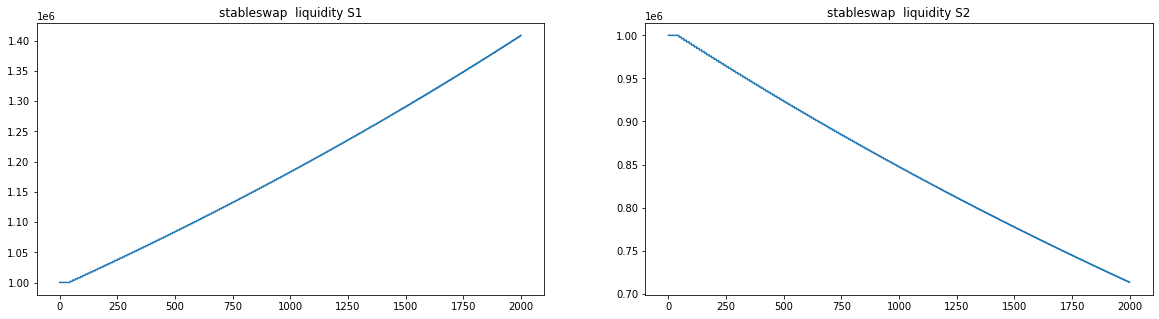

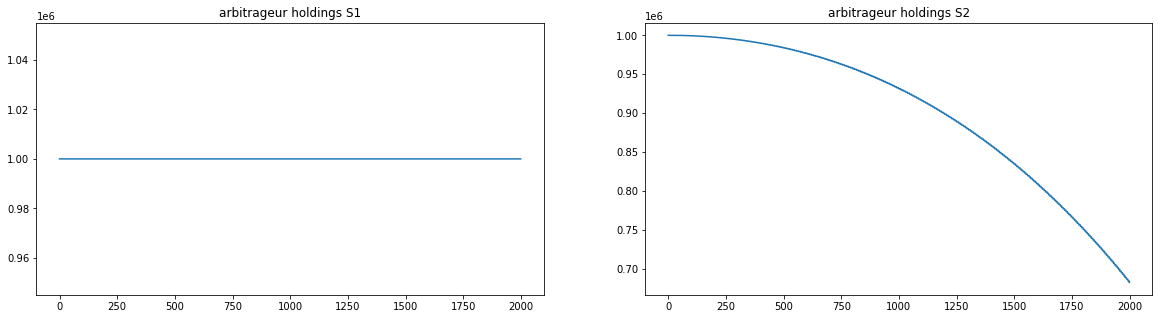

In [70]:
pu.plot(events1, pool='stableswap', prop='liquidity')
pu.plot(events1, agent='arbitrageur', prop='holdings', key=['S1', 'S2'])

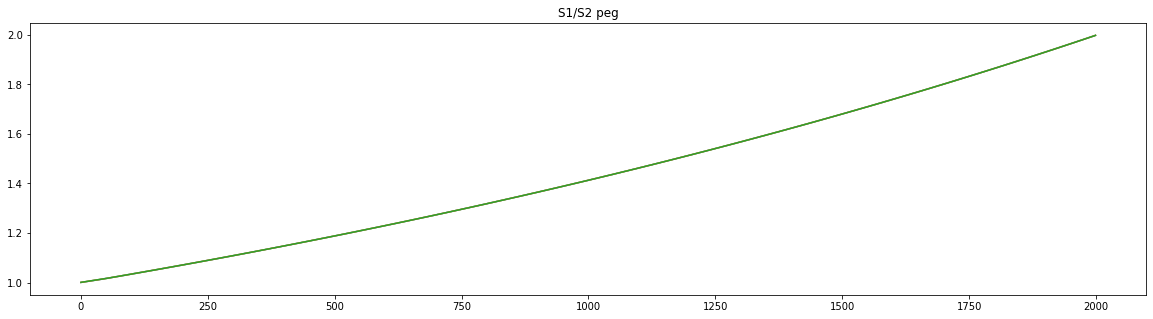

In [71]:
plt.figure(figsize=(20, 5))
for events in (events1, events2, events3):
    plt.plot([event.pools['stableswap'].buy_spot('S2', 'S1') for event in events])
    # plt.plot([event.external_market['S2'] for event in events])
plt.title('S1/S2 peg')
plt.show()

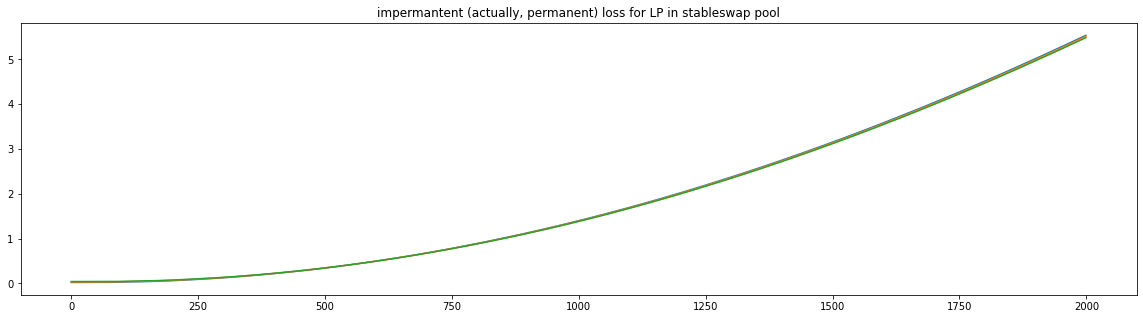

In [72]:
plt.figure(figsize=(20, 5))
for events in (events1, events2, events3):
    impermanent_loss = [
        (1 - event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market)
        / sum([amt * event.external_market[tkn] for tkn, amt in event.agents['non_LP'].holdings.items()])) * 100
        for event in events
    ]
    plt.plot(impermanent_loss)
plt.title('impermantent (actually, permanent) loss for LP in stableswap pool')
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, [event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market) for event in events])
plt.plot(total_supply, [sum(event.agents['non_LP'].holdings.values()) for event in events])

In [ ]:
events[-1].agents['non_LP'].holdings['S1']

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['stableswap'].price('S1', 'S2') for event in events])

In [ ]:
event = events[-1]
print(event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market))

In [ ]:
stablepool = event.pools['stableswap']
agent = event.agents['LP']

share_fraction = agent.holdings[stablepool.unique_id] / stablepool.shares
delta_tkns = {tkn: share_fraction * stablepool.liquidity[tkn] for tkn in stablepool.asset_list}  # delta_tkn is positive
print(delta_tkns)
# print([delta_tkns[tkn] * prices[tkn] for tkn in stablepool.asset_list])

In [30]:
impermanent_loss[-1] - impermanent_loss_2[-1]

29.134991282284272

In [13]:
stablepool.shares

2000999.7042730716

In [33]:
(
    events[-1].pools['stableswap'].cash_out(events[-1].agents['LP'], events[-1].external_market),
    event.pools['stableswap'].calculate_remove_liquidity(
        event.agents['LP'], event.agents['LP'].holdings['stableswap'], 'S1'
    )
)

(1416.592232209322, 1416.6751923540141)

In [74]:
repeg_factor

1.0003466336538454